### author: zabiralnazi@yahoo.com
> One-Shot-Learning with Siamese Network on a small Face dataset

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
% cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
import os
print(os.stat('data.zip').st_size/1000000000) # GigaBytes (approx)

0.006140496


In [0]:
# unzip to train folder
data_seg = 'data.zip'
import zipfile
zip_ref = zipfile.ZipFile(data_seg, 'r')
zip_ref.extractall('train_face')
zip_ref.close()

In [0]:
% cd /content/drive/My Drive/train_face/data

/content/drive/My Drive/train_face/data


In [0]:
! ls

0  1  2  3


In [0]:
# 4 classes for faces of 4 different people

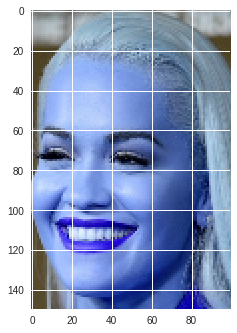

In [0]:
import cv2
import matplotlib.pyplot as plt
a = cv2.imread('0/rita0.jpg')
plt.imshow(cv2.resize(a, (100, 150)))
plt.show()

In [0]:
# siamese net
# https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb

from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (100, 150, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
#convnet.add(Conv2D(64,(3,3),activation='relu',
#                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
#convnet.add(MaxPooling2D())
#convnet.add(Conv2D(128,(3,3),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
#convnet.add(MaxPooling2D())
#convnet.add(Conv2D(256,(3,3),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
#convnet.add(Dense(1024,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#convnet.add(Dropout(0.2))

convnet.add(Dense(10,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(Dropout(0.2))
#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L2_layer = Lambda(lambda tensors:K.abs((tensors[0] - tensors[1])*(tensors[0] - tensors[1]))) # 
#call this layer on list of two input tensors.
L2_distance = L2_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L2_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['binary_accuracy'])

siamese_net.count_params()

1160661

In [0]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 150, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 150, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          8469248     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           sequential_1[1][0]               
          

In [0]:
x1 = np.zeros((100,105,105,1), dtype = 'float32')
x2 = np.zeros((100,105,105,1), dtype = 'float32')
x3 = [x1, x2]
x3 = np.array(x3)
y = np.zeros((100,), dtype = 'float32')

In [0]:
x3.shape

(2, 100, 105, 105, 1)

In [0]:
# prepare data
import glob

num_class = 4
files = []
for nc in range(4):
  path = str(nc) + '/*'
  fimg = []
  for f in glob.glob(path):
    fimg.append(f)
  files.append(fimg)
  

In [0]:
print(files)

[['0/rita0.jpg', '0/rita1.jpg', '0/rita2.jpg', '0/rita3.jpg', '0/rita4.jpg', '0/rita5.jpg', '0/rita6.jpg', '0/rita7.jpg', '0/rita8.jpg', '0/rita9.jpg'], ['1/nabil0.png', '1/nabil1.png', '1/nabil2.jpg', '1/nabil3.png', '1/nabil4.png', '1/nabil5.png', '1/nabil6.png', '1/nabil7.png', '1/nabil8.png', '1/nabil9.png'], ['2/adam0.jpg', '2/adam1.jpg', '2/adam2.jpg', '2/adam3.jpg', '2/adam4.jpg', '2/adam5.jpg', '2/adam6.jpg', '2/adam7.jpg', '2/adam8.jpg', '2/adam9.jpg'], ['3/jess0.jpg', '3/jess1.jpg', '3/jess2.jpg', '3/jess3.jpg', '3/jess4.jpg', '3/jess5.jpg', '3/jess6.jpg', '3/jess7.jpg', '3/jess8.jpg', '3/jess9.jpg']]


In [0]:
anchors = [a[0] for a in files]
print(anchors)

['0/rita0.jpg', '1/nabil0.png', '2/adam0.jpg', '3/jess0.jpg']


In [0]:
split_factor = 0.6
split = int(len(files[0])*split_factor)
trains = [a[1:split] for a in files]
tests = [a[split:] for a in files]
print(trains)
print(tests)

[['0/rita1.jpg', '0/rita2.jpg', '0/rita3.jpg', '0/rita4.jpg', '0/rita5.jpg'], ['1/nabil1.png', '1/nabil2.jpg', '1/nabil3.png', '1/nabil4.png', '1/nabil5.png'], ['2/adam1.jpg', '2/adam2.jpg', '2/adam3.jpg', '2/adam4.jpg', '2/adam5.jpg'], ['3/jess1.jpg', '3/jess2.jpg', '3/jess3.jpg', '3/jess4.jpg', '3/jess5.jpg']]
[['0/rita6.jpg', '0/rita7.jpg', '0/rita8.jpg', '0/rita9.jpg'], ['1/nabil6.png', '1/nabil7.png', '1/nabil8.png', '1/nabil9.png'], ['2/adam6.jpg', '2/adam7.jpg', '2/adam8.jpg', '2/adam9.jpg'], ['3/jess6.jpg', '3/jess7.jpg', '3/jess8.jpg', '3/jess9.jpg']]


In [0]:
anchor_imgs = [cv2.resize(cv2.imread(a,0), (100,150)) for a in anchors]
print(len(anchor_imgs))

4


In [0]:
train_imgs = [[cv2.resize(cv2.imread(a,0), (100,150)) for a in x] for x in trains]
print(len(train_imgs))
print(len(train_imgs[0]))

4
5


In [0]:
test_imgs = [[cv2.resize(cv2.imread(a,0), (100,150)) for a in x] for x in tests]
print(len(test_imgs))
print(len(test_imgs[0]))

4
4


In [0]:
# x1, x2, y
# x1 contains the anchor images
# x2 contains the training/test images
# if x1 and x2 contain the images of same class then y = 1
# if x1 and x2 do not contain the images of same class then y = 0

x1 = []
x2 = []
y = []

for a_class in range(num_class):
  # on a specific anchor image of a specific class
  for t_class in range(num_class):
    for imgs in train_imgs[t_class]:
      x1.append(np.reshape(anchor_imgs[a_class], (100,150,1)))
      x2.append(np.reshape(imgs, (100,150,1)))
      if a_class == t_class:
        y.append(1)
      else:
        y.append(0)

In [0]:
print(len(x1))
print(len(x2))
print(len(y))
print(x1[0].shape)
print(x2[0].shape)

80
80
80
(100, 150, 1)
(100, 150, 1)


In [0]:
x1 = np.array(x1)
x2 = np.array(x2)
y = np.array(y)
x1.shape

(80, 100, 150, 1)

In [0]:
x1 = x1/255.
x2 = x2/255.
print(np.max(x1))
print(np.min(x2))
print(np.max(x1))
print(np.min(x2))
print(np.mean(x1))
print(np.mean(x2))

In [0]:
import random
z = list(zip(x1,x2,y))
random.shuffle(z)

In [0]:
x1 = [a[0] for a in z]
x2 = [a[1] for a in z]
y = [a[2] for a in z]

In [0]:
x1 = np.array(x1)
x2 = np.array(x2)
y = np.array(y)
x1.shape

(80, 100, 150, 1)

In [0]:
y.shape

(80,)

In [0]:
y_cop = y[:]
y_cop[y==1.] = 0.
y_cop[y==0.] = 1.

In [0]:
class_weight = {0: 1.,
                1: 1.}

In [0]:
siamese_net.fit([x1, x2],y_cop,epochs = 40, batch_size = 16, verbose = 1, validation_split = 0.3,
               class_weight = class_weight, shuffle = True)

Train on 56 samples, validate on 24 samples
Epoch 1/40
56/56 [==============================] - 0s 2ms/step - loss: 0.9167 - binary_accuracy: 0.4107 - val_loss: 0.5527 - val_binary_accuracy: 1.0000
Epoch 2/40
56/56 [==============================] - 0s 2ms/step - loss: 1.0008 - binary_accuracy: 0.2500 - val_loss: 0.5525 - val_binary_accuracy: 1.0000
Epoch 3/40
56/56 [==============================] - 0s 2ms/step - loss: 0.9233 - binary_accuracy: 0.3393 - val_loss: 0.5522 - val_binary_accuracy: 1.0000
Epoch 4/40
56/56 [==============================] - 0s 2ms/step - loss: 0.9337 - binary_accuracy: 0.3036 - val_loss: 0.5519 - val_binary_accuracy: 1.0000
Epoch 5/40
56/56 [==============================] - 0s 2ms/step - loss: 0.9071 - binary_accuracy: 0.3929 - val_loss: 0.5516 - val_binary_accuracy: 1.0000
Epoch 6/40
56/56 [==============================] - 0s 2ms/step - loss: 0.9114 - binary_accuracy: 0.4107 - val_loss: 0.5513 - val_binary_accuracy: 1.0000
Epoch 7/40
56/56 [==============

In [0]:
# x1, x2, y
# x1 contains the anchor images
# x2 contains the training/test images
# if x1 and x2 contain the images of same class then y = 1
# if x1 and x2 do not contain the images of same class then y = 0

x1 = []
x2 = []
y = []

for a_class in range(num_class):
  # on a specific anchor image of a specific class
  for t_class in range(num_class):
    for imgs in train_imgs[t_class]:
      x1.append(np.reshape(anchor_imgs[a_class], (100,150,1)))
      x2.append(np.reshape(imgs, (100,150,1)))
      if a_class == t_class:
        y.append(1)
      else:
        y.append(0)